## Imports

In [117]:
#Commonted out the below lines as the packages are already installed in the environment

# !pip install timm
# !pip install nibabel
# !pip install nilearn
# !pip install light-the-torch && ltt install torch
#!pip install torchio

import tensorflow as tf
#for neuroimaging data
import nibabel as nib
import nilearn as nilearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import os
import torchio as tio



In [118]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [119]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

CUDA is available!


In [120]:
# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {torch.cuda.get_device_name()} for inference' if torch.cuda.is_available() else 'Using CPU for inference')

Using NVIDIA GeForce RTX 3060 Laptop GPU for inference


## Dataset 

In [121]:


root_dir = 'Dataset'

# List all subdirectories in the root directory
subdirectories = [x[0] for x in os.walk(root_dir)]

dataset = []

# Iterate over the subdirectories
for subdir in subdirectories:
    # Check if the subdirectory contains 'anat' in its path
    if 'anat' in subdir:
        # List all files in the subdirectory
        files = os.listdir(subdir)
        # Iterate over the files
        for file in files:
            # Check if the file is a .nii.gz file
            if file.endswith('.nii.gz'):
                file_path = os.path.join(subdir, file)
                # Load the Nifti image using TorchIO
                subject = tio.Subject(
                    mri = tio.ScalarImage(file_path),
                )
                dataset.append(subject)
       

# Print the number of images in the dataset
print('Number of Images in Dataset: ' + str(len(dataset)))

print('First Image in Dataset: ')
print(dataset[0].shape)


Number of Images in Dataset: 777
First Image in Dataset: 
(1, 256, 200, 256)


## Import Labels

In [122]:
# check if a file named participants.tsv exists in the each of the subfolder under the root directory
# If it exists, load the file and display the contents
for subdir in subdirectories:
    if os.path.exists(os.path.join(subdir, 'participants.csv')):
        print('Found participants.tsv in ' + subdir)
        df = pd.read_csv(os.path.join(subdir, 'participants.csv'), sep=',', header=0)
df.head()

Found participants.tsv in Dataset\KKI
Found participants.tsv in Dataset\NeuroIMAGE
Found participants.tsv in Dataset\NYU
Found participants.tsv in Dataset\OHSU
Found participants.tsv in Dataset\Peking_1
Found participants.tsv in Dataset\Peking_2
Found participants.tsv in Dataset\Peking_3


,participant_id,gender,age,handedness,dx,secondary_dx,adhd_measure,adhd_index,inattentive,hyper_impulsive,...,performance_iq,full2_iq,full4_iq,med_status,qc_rest_1,qc_rest_2,qc_rest_3,qc_rest_4,qc_anatomical_1,qc_anatomical_2
0,1050345,Male,12.67,Right,Typically Developing Children,NaN,ADHD Rating Scale IV (ADHD-RS),24,12,12,...,127,NaN,128,Medication Naive,Pass,NaN,NaN,NaN,Pass,NaN
1,1132854,Male,13.92,Right,Typically Developing Children,NaN,ADHD Rating Scale IV (ADHD-RS),28,15,13,...,126,NaN,125,Medication Naive,Pass,NaN,NaN,NaN,Pass,NaN
2,1356553,Male,11.75,Right,ADHD-Combined,LD,ADHD Rating Scale IV (ADHD-RS),56,30,26,...,98,NaN,109,Medication Naive,Pass,NaN,NaN,NaN,Pass,NaN
3,1399863,Male,12.83,Right,ADHD-Combined,"ODD, LD",ADHD Rating Scale IV (ADHD-RS),64,29,35,...,85,NaN,94,Medication Naive,Pass,NaN,NaN,NaN,Pass,NaN
4,1404738,Male,12.58,Right,Typically Developing Children,NaN,ADHD Rating Scale IV (ADHD-RS),21,9,12,...,115,NaN,120,Medication Naive,Pass,NaN,NaN,NaN,Pass,NaN


In [123]:
for subject in dataset:
    adhd_label = df['dx'].values[0]
    if adhd_label != 'Typically Developing Children':
        adhd_label = 'ADHD'
    subject['adhd'] = adhd_label

# Print the first 5 labels
print('First 5 Labels: ' + str([subject['adhd'] for subject in dataset[:5]]))

First 5 Labels: ['Typically Developing Children', 'Typically Developing Children', 'Typically Developing Children', 'Typically Developing Children', 'Typically Developing Children']


ADHD Label: Typically Developing Children


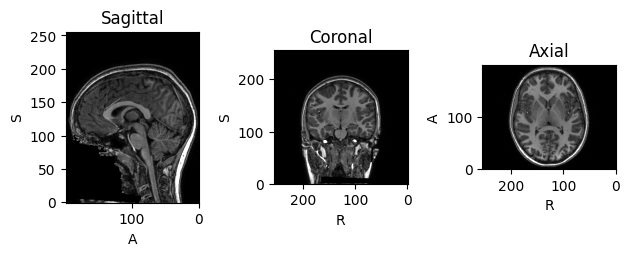

ADHD Label: Typically Developing Children


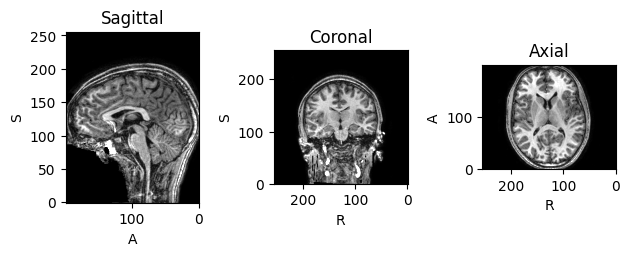

ADHD Label: Typically Developing Children


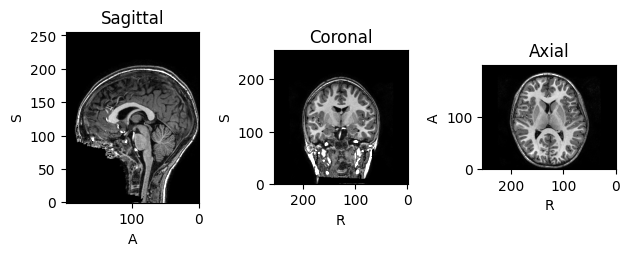

ADHD Label: Typically Developing Children


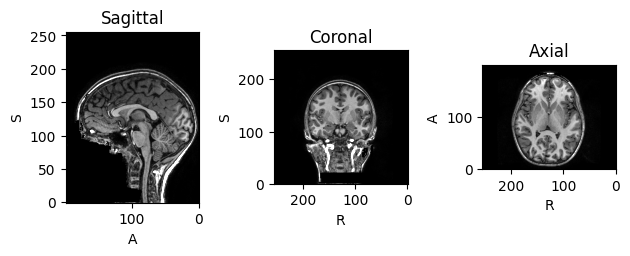

ADHD Label: Typically Developing Children


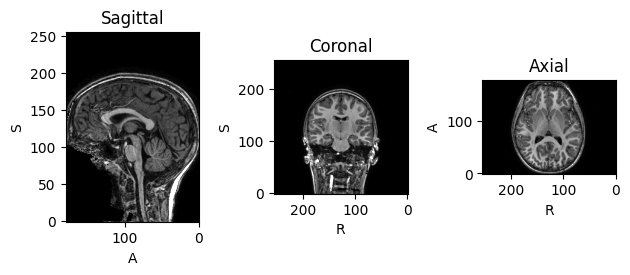

In [124]:
for i in range(5):
    subject = dataset[i]
    image = subject['mri']
    print('ADHD Label: ' + subject['adhd'])
    image.plot()
    plt.show()

In [125]:
transforms = [
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.RandomAffine(),
    tio.RandomBiasField(),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.CropOrPad((256, 256, 256)),
    #squeeze image
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
]
transform = tio.Compose(transforms)
subjects_dataset = tio.SubjectsDataset(dataset, transform=transform)
print(len(subjects_dataset))

777


ADHD Label: Typically Developing Children


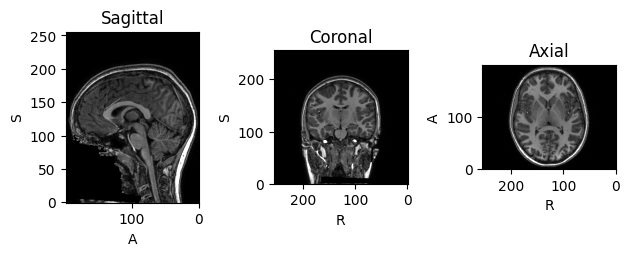

torch.Size([1, 256, 200, 256])
ADHD Label: Typically Developing Children


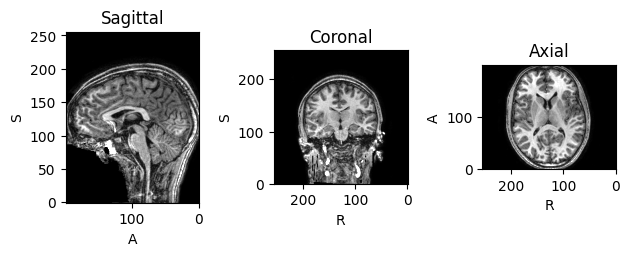

torch.Size([1, 256, 200, 256])
ADHD Label: Typically Developing Children


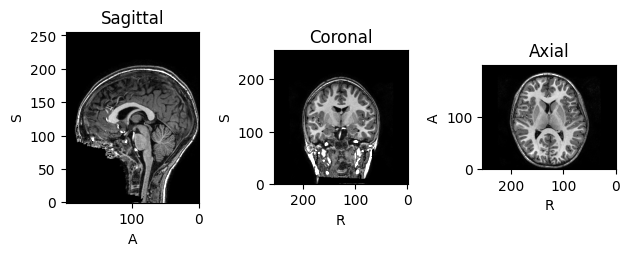

torch.Size([1, 256, 200, 256])
ADHD Label: Typically Developing Children


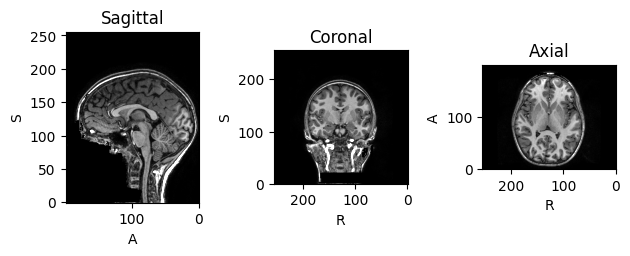

torch.Size([1, 256, 200, 256])
ADHD Label: Typically Developing Children


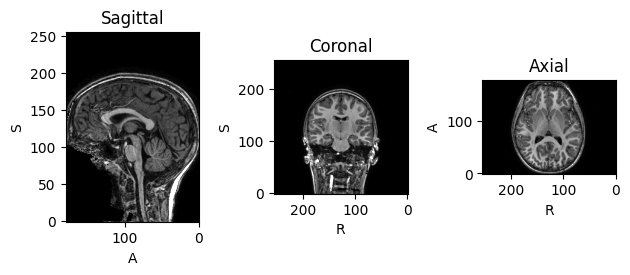

torch.Size([1, 256, 180, 256])


In [126]:
for i in range(5):
    subject = dataset[i]
    image = subject['mri']
    print('ADHD Label: ' + subject['adhd'])
    image.plot()
    plt.show()
    print(image.data.shape)

## Modelling

In [134]:
# split the torchio dataset into train/test with a 80/20 ratio
n = len(subjects_dataset)
n_train = int(0.8 * n)
n_val = n - n_train
train_dataset, val_dataset = torch.utils.data.random_split(subjects_dataset, [n_train, n_val])

# Create a DataLoader for the training dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

# Create a DataLoader for the validation dataset
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)



# Print the number of batches in the training and validation loaders
print('Number of Batches in Training Loader: ' + str(len(train_loader)))

print('Number of Batches in Validation Loader: ' + str(len(val_loader)))



Number of Batches in Training Loader: 156
Number of Batches in Validation Loader: 10


In [140]:
import torch
import torchvision.models as models

# Load the pre-trained CNN model for neuorimaging data
model = models.efficientnet_v2_s(pretrained=True)
# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the model architecture
print(model)
model = model.to(device)



c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gelo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [144]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define the number of epochs
num_epochs = 10

# Define the lists to store the training and validation losses
train_losses = []
val_losses = []

# Iterate over the epochs

for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    running_loss = 0.0
    # Iterate over the training data loader
    for i, batch in enumerate(train_loader):
        inputs = batch['mri']['data'].to(device)
        labels = batch['adhd']['data'].to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute the loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Optimize
        optimizer.step()
        running_loss += loss.item()
    # Append the training loss
    train_losses.append(running_loss / len(train_loader))
    # Set the model to evaluation mode
    model.eval()
    val_loss = 0.0
    # Iterate over the validation data loader
    for i, batch in enumerate(val_loader):
        inputs = batch['mri']['data'].to(device)
        labels = batch['adhd'].to(device)
        # Disable gradient computation
        with torch.no_grad():
            # Forward pass
            outputs = model(inputs)
            # Compute the loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    # Append the validation loss
    val_losses.append(val_loss / len(val_loader))
    # Step the learning rate scheduler
    scheduler.step()
    # Print the training and validation loss
    print('Epoch {}/{} - Training Loss: {:.6f}, Validation Loss: {:.6f}'.format(epoch + 1, num_epochs, train_losses[-1], val_losses[-1]))

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), 'model.pth')

TypeError: list indices must be integers or slices, not str